In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
from collections import Counter

/Users/michal/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df = pd.read_csv('../data/fer2013/fer2013.csv')
df.sample(5)

,emotion,pixels,Usage
34894,3,160 124 154 148 96 105 164 169 81 53 79 89 98 ...,PrivateTest
23106,0,67 60 95 139 151 138 136 136 122 109 98 102 97...,Training
16667,3,78 34 20 32 50 37 32 30 22 17 15 14 16 20 25 2...,Training
1557,4,134 152 180 111 71 151 153 128 32 125 155 156 ...,Training
14780,2,60 65 73 62 43 48 69 93 107 115 111 105 105 11...,Training


In [3]:
def error_rate(pred, target):
    return np.mean(pred!=target)

In [4]:
def classification_rate(p, t):
    return np.mean(p == t)

In [5]:
def ohe(labels):
    ohe_lab = np.zeros((labels.shape[0], len(set(labels))))
    for i in range(len(labels)):
        ohe_lab[i, labels[i]] = 1
    return ohe_lab     

In [6]:
def rearrange(X):
    return (X.transpose(0, 2, 3, 1) / 255).astype(np.float32)

In [7]:
Y_all = df['emotion'].astype(int)
X_all = []
for i in df['pixels']:
    X_all.append([int(p) for p in i.split()]) #acts like getData()
X_all, Y_all = np.array(X_all), np.array(Y_all)
X_all = np.reshape(X_all, (X_all.shape[0], 1, 48, 48)) #acts like getImageData()

In [8]:
from collections import Counter
Counter(Y_all)

Counter({0: 4953, 1: 547, 2: 5121, 3: 8989, 4: 6077, 5: 4002, 6: 6198})

In [9]:
X = rearrange(X_all)
Y = ohe(Y_all)

In [10]:
print(X.shape)
print(type(X))
print(Y.shape)
print(type(Y))

(35887, 48, 48, 1)
<class 'numpy.ndarray'>
(35887, 7)
<class 'numpy.ndarray'>


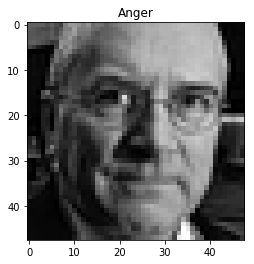

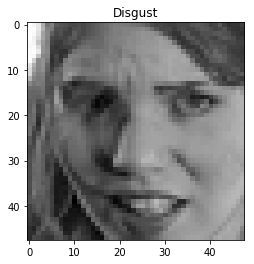

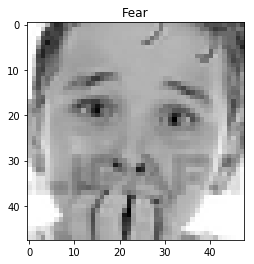

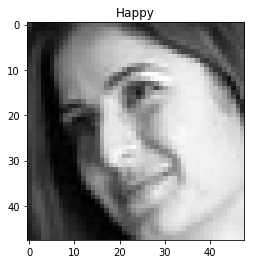

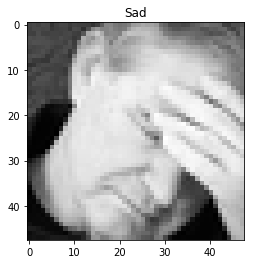

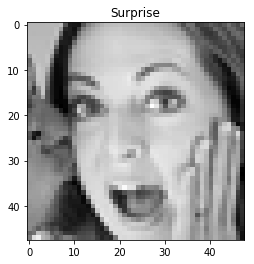

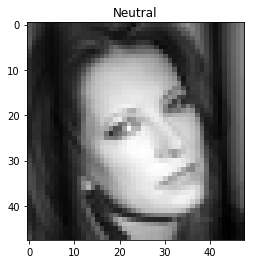

In [11]:
# show one of each emtion randomly
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

for i in range(7):
    x, y = X_all[Y_all==i], Y_all[Y_all==i]
    N = len(y)
    j = np.random.choice(N)
    plt.imshow(x[j].reshape(48,48), cmap='gray')
    plt.title(label_map[y[j]])
    plt.show()

In [12]:
max_iter = 50
print_period = 20
lr = 1e-5
reg = 1e-2

In [13]:
X_train = X[:-1000]
Y_train = Y[:-1000]
X_test = X[-1000:]
Y_test = Y[-1000:]

In [14]:
N = X_train.shape[0]
batch_size = 256
num_batches = N//batch_size

In [15]:
# get TF variables for the inputs, X and targets T
ftX = tf.placeholder(tf.float32, shape=(None, 48, 48, 1), name='X')
ftT = tf.placeholder(tf.float32, shape=(None, 7), name='T')

In [16]:
conv1_layer = tf.layers.conv2d(ftX, filters=16, kernel_size=3, strides=1, 
                                   padding="SAME", use_bias=True, activation=tf.nn.relu,
                                   kernel_initializer=tf.contrib.layers.xavier_initializer())
conv1_layer_mpool = tf.layers.max_pooling2d(conv1_layer, pool_size=2, strides=2)

conv2_layer = tf.layers.conv2d(conv1_layer_mpool, filters=32, kernel_size=3, strides=1, 
                                   padding="SAME", use_bias=True, activation=tf.nn.relu,
                                   kernel_initializer=tf.contrib.layers.xavier_initializer())
conv2_layer_mpool = tf.layers.max_pooling2d(conv2_layer, pool_size=2, strides=2)

conv3_layer = tf.layers.conv2d(conv2_layer_mpool, filters=64, kernel_size=3, strides=1, 
                                   padding="SAME", use_bias=True, activation=tf.nn.relu,
                                   kernel_initializer=tf.contrib.layers.xavier_initializer())
conv3_layer_mpool = tf.layers.max_pooling2d(conv3_layer, pool_size=2, strides=2)

Z3_shape = conv3_layer_mpool.get_shape().as_list()
Z3_r = tf.reshape(conv3_layer_mpool, [-1, np.prod(Z3_shape[1:])])

dense1_layer = tf.layers.dense(inputs=Z3_r, units=512, use_bias=True, activation=None)
dense1_layer_activated = tf.nn.relu(dense1_layer)

dense2_layer = tf.layers.dense(inputs=dense1_layer_activated, units=256, use_bias=True, activation=None)
dense2_layer_activated = tf.nn.relu(dense2_layer)

dense3_layer = tf.layers.dense(inputs=dense2_layer_activated, units=128, use_bias=True, activation=None)
dense3_layer_activated = tf.nn.relu(dense3_layer)

# Output Layer 
Yish = tf.layers.dense(inputs=dense3_layer_activated, units=7, activation=None)

In [17]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    labels=ftT, logits=Yish))

In [18]:
pred = tf.argmax(Yish, 1)

In [19]:
train_op = tf.train.RMSPropOptimizer(lr, decay=0.999, momentum=0.99).minimize(cost)

In [20]:
LL = []
error = []
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(max_iter):
        X_train, Y_train = shuffle(X_train, Y_train)
        for j in range(num_batches):
            X_batch = X_train[(j*batch_size):(j*batch_size+batch_size)]
            Y_batch = Y_train[(j*batch_size):(j*batch_size+batch_size)]
        
            sess.run(train_op, feed_dict = {ftX: X_batch, ftT: Y_batch})
            if j % print_period == 0:
                cost_val = sess.run(cost, feed_dict={ftX: X_test, ftT: Y_test})
                pred_val = sess.run(pred, feed_dict={ftX: X_test})
                err = error_rate(pred_val, Y_test.argmax(axis = 1))
                print(i,j,cost_val,err)
                LL.append(cost_val)
                error.append(err)

0 0 1.9412637 0.782
0 20 1.9405744 0.779
0 40 1.9389054 0.779
0 60 1.936471 0.778
0 80 1.9335369 0.779
0 100 1.9303054 0.779
0 120 1.9268395 0.779
1 0 1.9239595 0.78
1 20 1.920251 0.78
1 40 1.9165281 0.78
1 60 1.9126811 0.78
1 80 1.9088484 0.78
1 100 1.905141 0.78
1 120 1.9016134 0.78
2 0 1.8989272 0.78
2 20 1.8957478 0.78
2 40 1.8928216 0.78
2 60 1.890053 0.78
2 80 1.8874274 0.78
2 100 1.8849245 0.78
2 120 1.8825341 0.78
3 0 1.880696 0.78
3 20 1.878489 0.78
3 40 1.8763435 0.78
3 60 1.8742601 0.78
3 80 1.8722351 0.78
3 100 1.870267 0.78
3 120 1.8683048 0.78
4 0 1.8666629 0.78
4 20 1.8646611 0.78
4 40 1.8626809 0.78
4 60 1.8606187 0.78
4 80 1.858468 0.78
4 100 1.8562822 0.78
4 120 1.8540642 0.78
5 0 1.8523414 0.78
5 20 1.8503214 0.78
5 40 1.8484172 0.78
5 60 1.8465447 0.78
5 80 1.844743 0.78
5 100 1.8431052 0.78
5 120 1.8414574 0.78
6 0 1.8402569 0.78
6 20 1.8389039 0.78
6 40 1.8376228 0.78
6 60 1.8364629 0.78
6 80 1.8354725 0.78
6 100 1.8345162 0.78
6 120 1.8336408 0.78
7 0 1.833012 0.

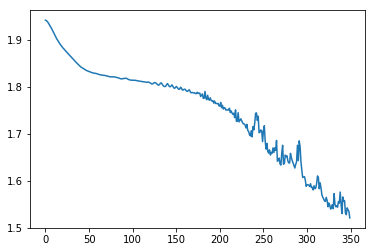

In [21]:
plt.plot(LL)
plt.show()

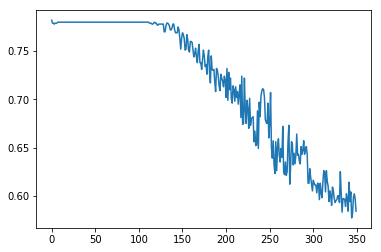

In [22]:
plt.plot(error)
plt.show()